This is not the latest version, the latest version is in the hard drive. I will update it afterwards

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import keras 
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import GlorotUniform

2024-12-01 08:36:55.376282: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-01 08:36:55.399372: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-01 08:36:55.399398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-01 08:36:55.400044: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 08:36:55.403934: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Set the environment variable to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
labels_df = pd.read_csv("/home/elahed/users/elahe/project with aws/all_steering_concat_plus_3000_plus_19000_plus_10000_normalized_4000_with_class.csv")
images_directory = '/home/elahed/users/elahe/project with aws/all_mix/'
labels = []
image_path = []
Image_and_label = []
steering_labels = []
# Iterate through the rows of the DataFrame
for index, row in labels_df.iterrows():
    labels.append(row['Steering'])
    steering_labels.append(row['Steering_Class'])
    image_path.append(os.path.join(images_directory, row['Image_Fname']+'.png'))  # Replace with the actual column name
    Image_and_label.append([os.path.join(images_directory, row['Image_Fname']+'.png'),row['Steering'],row['Throttle'],row['Brake']])

In [4]:
print(labels)

[-0.0001757331192493, -0.0290558170527219, -0.1157644242048263, -0.2011808156967163, -0.238523855805397, -0.2518028318881988, -0.3324058353900909, -0.2487750351428985, -0.167343869805336, -0.0023876449558883, 0.0, -0.0629938170313835, -0.0634987875819206, -0.0326580218970775, -0.0685752630233764, -0.0836720541119575, -0.046024352312088, -0.1219454854726791, -0.0946602448821067, -0.0856046751141548, -0.0696641653776168, -0.0862034857273101, -0.0622783452272415, -0.0284488014876842, -0.0559873953461647, -0.0418493002653121, -0.0448765717446804, -0.0551973357796669, -0.1086793765425682, -0.0587753430008888, -0.0655750036239624, -0.1178614124655723, -0.0470511801540851, -0.0145525112748146, -0.0251891426742076, -0.0871316045522689, -0.0933011397719383, -0.0363113097846508, -0.0739417821168899, -0.0522760711610317, -0.10768523812294, -0.0739441886544227, -0.0685727298259735, -0.0712684914469719, -0.0345828086137771, -0.0479890592396259, -0.0799744129180908, -0.0286721009761095, -0.036832377

In [5]:
print(steering_labels)

[10, 10, 9, 8, 8, 8, 7, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 11, 14, 14, 14, 13, 13, 11, 11, 11, 11, 9, 9, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 8, 8, 8, 9, 8, 9, 8, 9, 8, 9, 9, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 10, 10, 10, 10, 10, 9, 10, 9, 10, 9, 10, 11, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 9, 9, 10, 10, 11, 10, 10, 12, 12, 15, 13, 14, 15, 13, 11, 11, 11, 11, 10, 9, 9, 8, 8, 9, 9, 9, 9, 9, 9, 8, 8, 8, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 11, 11, 11, 11, 10, 10, 11, 10, 12, 14, 16, 15, 14, 9, 9, 8, 8, 8, 9, 10, 9, 9, 9, 10, 10, 9, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 9, 10, 9, 9, 9, 10, 10, 10, 11, 12, 13, 14, 13, 15, 14, 12, 10, 11, 9, 9, 9, 8, 9, 9, 9, 9, 8, 9, 9, 9, 9, 8, 9, 9, 9, 9, 8, 9, 9, 9, 9, 10, 11, 11, 11, 11, 12, 14, 13, 14, 13, 14, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 9, 8, 9, 8, 9, 9, 9

In [6]:
#### Code for discretizing the steering values ####
'''
import numpy as np
import pandas as pd

# Load the dataset
file_path = '/home/elahed/users/elahe/project with aws/all_steering_concat_plus_3000_plus_19000_plus_10000_normalized_4000.csv'
data = pd.read_csv(file_path)


# Define the custom intervals and class labels
custom_intervals = [
    -1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,
    0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1
]  # 21 endpoints for 20 intervals

custom_labels = list(range(1, len(custom_intervals)))  # Classes 1 to 20

# Assign each steering value to a class based on the intervals
data['Steering_Class'] = pd.cut(
    data['Steering'],
    bins=custom_intervals,
    labels=custom_labels,
    include_lowest=True
)



# Save the updated dataset
output_path = '/home/elahed/users/elahe/project with aws/all_steering_concat_plus_3000_plus_19000_plus_10000_normalized_4000_with_class.csv'
data.to_csv(output_path, index=False)

# Print a preview
#print(data[['Steering', 'Steering_Class']].head())


# Validate the class range
print(f"Classes range: {data['Steering_Class'].min()} to {data['Steering_Class'].max()}")
'''

'\nimport numpy as np\nimport pandas as pd\n\n# Load the dataset\nfile_path = \'/home/elahed/users/elahe/project with aws/all_steering_concat_plus_3000_plus_19000_plus_10000_normalized_4000.csv\'\ndata = pd.read_csv(file_path)\n\n\n# Define the custom intervals and class labels\ncustom_intervals = [\n    -1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,\n    0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1\n]  # 21 endpoints for 20 intervals\n\ncustom_labels = list(range(1, len(custom_intervals)))  # Classes 1 to 20\n\n# Assign each steering value to a class based on the intervals\ndata[\'Steering_Class\'] = pd.cut(\n    data[\'Steering\'],\n    bins=custom_intervals,\n    labels=custom_labels,\n    include_lowest=True\n)\n\n\n\n# Save the updated dataset\noutput_path = \'/home/elahed/users/elahe/project with aws/all_steering_concat_plus_3000_plus_19000_plus_10000_normalized_4000_with_class.csv\'\ndata.to_csv(output_path, index=False)\n\n# Print a preview\n#print(data[[\'St

In [7]:
len(labels)

47312

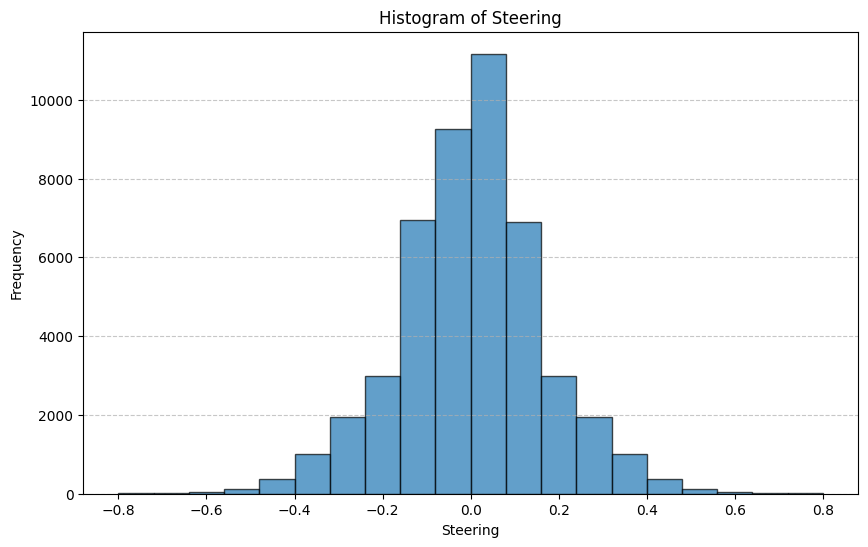

In [8]:
import matplotlib.pyplot as plt

# Plot the histogram for the 'Steering' column
column_name = 'Steering'

plt.figure(figsize=(10, 6))
plt.hist(labels_df[column_name], bins=20, edgecolor='black', alpha=0.7)
plt.title(f"Histogram of {column_name}")
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [9]:
def flipping(img, steering):
    flip_image = cv2.flip(img,1)
    flip_steering = steering*-1.0
    return flip_image, flip_steering

def brightness(img,steering):
    bright_limit = (-0.5, 0.15)
    brightness_multiplier = 1.0 + np.random.uniform(low=bright_limit[0], high=bright_limit[1])
    image_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    image_hsv[:,:,2] = image_hsv[:,:,2] * brightness_multiplier
    bright_image = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)
    return bright_image , steering

In [10]:
class My_Custom_Generator1(keras.utils.Sequence):
  
    def __init__(self, image_filenames, labels, class_labels, batch_size, augment):
        """
        Initialize the custom generator.

        Args:
        - image_filenames: List of file paths to images.
        - labels: List of continuous steering values.
        - class_labels: List of discretized class labels corresponding to the steering values.
        - batch_size: Batch size for the generator.
        - augment: List of augmentation options (e.g., ['Flip', 'bright']).
        """
        self.image_filenames = image_filenames
        self.labels = labels  # Continuous steering values
        self.class_labels = class_labels  # Discretized class labels
        self.batch_size = batch_size
        self.augment = augment
    
    def __len__(self):
        """
        Return the number of batches per epoch.
        """
        return (np.floor(len(self.image_filenames) / float(self.batch_size))).astype(np.int32)
  
    def __getitem__(self, idx):
        """
        Generate a batch of data.
        """
        # Get the batch data
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y_continuous = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y_classes = self.class_labels[idx * self.batch_size : (idx+1) * self.batch_size]
        
        inputs = []
        outputs_continuous = []
        outputs_classes = []

        # Process each image and label in the batch
        for filename, continuous, class_label in zip(batch_x, batch_y_continuous, batch_y_classes):
            
            # Load and preprocess the image
            image = cv2.resize(cv2.imread(filename), (160, 160))
            inputs.append(image)

            # Add the labels
            outputs_continuous.append(continuous)
            outputs_classes.append(class_label)
            #print('outputs_continuous',outputs_continuous)
            #print('outputs_classes',outputs_classes)

            # Apply augmentations
            if self.augment[0] == 'Flip':
                aug_image, aug_steer = flipping(image, continuous)
                inputs.append(aug_image)
                outputs_continuous.append(aug_steer)
                outputs_classes.append(class_label)  # Augmentation doesn't change class label

            if self.augment[1] == 'bright':
                aug_image, aug_steer = brightness(image, continuous)
                inputs.append(aug_image)
                outputs_continuous.append(aug_steer)
                outputs_classes.append(class_label)  # Augmentation doesn't change class label


        # Convert inputs and outputs to numpy arrays
        inputs_final = np.array(inputs).astype("float32") / 255.0  # Normalize images
        outputs_continuous = np.array(outputs_continuous).astype("float32")
        outputs_classes = np.array(outputs_classes).astype("int32")  # Ensure class labels are integers
            # Validate inputs and labels
        if np.any(np.isnan(inputs_final)) or np.any(np.isinf(inputs_final)):
            raise ValueError("NaN or Inf detected in input images!")

        if np.any(np.isnan(outputs_continuous)) or np.any(np.isinf(outputs_continuous)):
            raise ValueError("NaN or Inf detected in continuous labels!")

        if np.any(np.isnan(outputs_classes)) or np.any(np.isinf(outputs_classes)):
            raise ValueError("NaN or Inf detected in discrete labels!")

        # Return inputs and both outputs
        #return inputs_final, {"continuous_output": outputs_continuous, "discrete_output": outputs_classes}
        return inputs_final, [outputs_continuous , outputs_classes]


In [11]:
batch_size = 32
# Combine labels and class_labels for consistent splitting
combined_labels = list(zip(labels, steering_labels))
X_train_data, X_valid_data, combined_train_labels, combined_valid_labels = train_test_split(image_path,combined_labels, test_size=0.1,shuffle=True)
# Separate continuous and class labels after the split
y_train_continuous, y_train_classes = zip(*combined_train_labels)
y_valid_continuous, y_valid_classes = zip(*combined_valid_labels)
train_generator = My_Custom_Generator1(X_train_data, y_train_continuous,y_train_classes, batch_size,augment =["no","bright"] )
valid_generator = My_Custom_Generator1(X_valid_data, y_valid_continuous,y_valid_classes, batch_size,augment =["no","bright"] )

In [12]:
#### for test with all data
'''
batch_size = 32
# Combine labels and class_labels for consistent splitting
train_generator = My_Custom_Generator1(image_path, labels, steering_labels, batch_size,augment =["no","bright"] )
'''

'\nbatch_size = 32\n# Combine labels and class_labels for consistent splitting\ntrain_generator = My_Custom_Generator1(image_path, labels, steering_labels, batch_size,augment =["no","bright"] )\n'

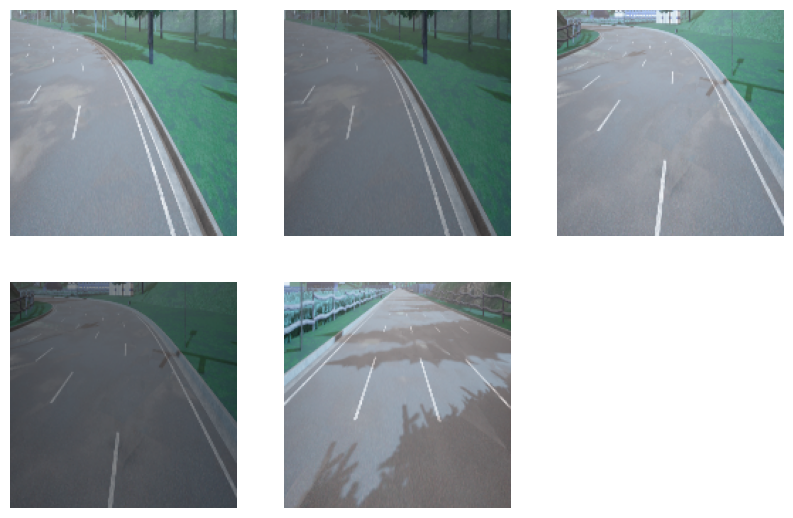

In [13]:
# Generate and plot 5 augmented images
plt.figure(figsize=(10, 10))
for i in range(5):
    augmented_image = train_generator[0][0][i]
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image)
    plt.axis('off')
plt.show()

In [14]:
train_generator[0][1][0]

array([-1.17725156e-01, -1.17725156e-01, -3.77979055e-02, -3.77979055e-02,
        5.93004690e-04,  5.93004690e-04,  1.60322458e-01,  1.60322458e-01,
        1.50549188e-01,  1.50549188e-01,  1.95920765e-02,  1.95920765e-02,
        7.01055303e-02,  7.01055303e-02,  3.59446555e-01,  3.59446555e-01,
        2.55196035e-01,  2.55196035e-01, -4.58913207e-01, -4.58913207e-01,
        2.86420256e-01,  2.86420256e-01,  3.41575331e-04,  3.41575331e-04,
       -1.87753662e-01, -1.87753662e-01, -4.84291464e-01, -4.84291464e-01,
        1.50614331e-04,  1.50614331e-04,  6.72538579e-02,  6.72538579e-02,
        5.48660085e-02,  5.48660085e-02,  3.08845490e-02,  3.08845490e-02,
       -1.54952332e-03, -1.54952332e-03, -3.53452712e-01, -3.53452712e-01,
        2.32776895e-01,  2.32776895e-01, -3.05853388e-03, -3.05853388e-03,
        1.19938940e-01,  1.19938940e-01,  3.98321636e-02,  3.98321636e-02,
        1.17610164e-01,  1.17610164e-01, -3.79779376e-02, -3.79779376e-02,
       -6.16476953e-01, -

In [15]:
len(X_train_data)

42580

In [16]:
X_train_data

['/home/elahed/users/elahe/project with aws/all_mix/image_2024-05-15-46-23_01545711.png',
 '/home/elahed/users/elahe/project with aws/all_mix/image_2024-05-15-18-37_00993973.png',
 '/home/elahed/users/elahe/project with aws/all_mix/image_2024-05-17-40-39_00405531_augmented_flipped.png',
 '/home/elahed/users/elahe/project with aws/all_mix/image_2024-05-08-45-45_00278996.png',
 '/home/elahed/users/elahe/project with aws/all_mix/image_2024-05-11-24-58_00023405_augmented_flipped.png',
 '/home/elahed/users/elahe/project with aws/all_mix/image_2024-05-13-09-47_01169696.png',
 '/home/elahed/users/elahe/project with aws/all_mix/image_2024-05-18-48-35_00695485_augmented_flipped.png',
 '/home/elahed/users/elahe/project with aws/all_mix/image_2024-05-09-09-37_04964159_augmented_flipped.png',
 '/home/elahed/users/elahe/project with aws/all_mix/image_2024-05-08-47-19_00283885_augmented_flipped.png',
 '/home/elahed/users/elahe/project with aws/all_mix/image_2024-05-16-27-31_00131104.png',
 '/home/el

In [17]:
y_train_continuous

(-0.1177251562476158,
 -0.0377979055047035,
 0.0005930046900175,
 0.1603224575519561,
 0.1505491882562637,
 0.0195920765399932,
 0.070105530321598,
 0.3594465553760528,
 0.2551960349082947,
 -0.4589132070541382,
 0.2864202558994293,
 0.0003415753308217,
 -0.1877536624670028,
 -0.4842914640903473,
 0.0001506143307778,
 0.0672538578510284,
 0.0548660084605217,
 0.0308845490217208,
 -0.0015495233237743,
 -0.3534527122974396,
 0.2327768951654434,
 -0.0030585338827222,
 0.1199389398097992,
 0.0398321636021137,
 0.1176101639866828,
 -0.0379779376089572,
 -0.6164769530296326,
 0.1295466125011444,
 -0.0976307690143585,
 -0.1402078419923782,
 0.0425358228385448,
 -0.1871626675128936,
 0.0645401254296302,
 0.2010050117969513,
 -0.3862859904766083,
 -0.1865177899599075,
 -0.1648670136928558,
 0.0495626106858253,
 -0.163784772157669,
 -0.0893209502100944,
 0.1142075806856155,
 -0.1281206309795379,
 0.2099754214286804,
 -0.2366377711296081,
 0.0138950971886515,
 -0.2086250036954879,
 0.135554462671

In [18]:
y_train_classes

(9,
 10,
 11,
 12,
 12,
 11,
 11,
 14,
 13,
 6,
 13,
 11,
 9,
 6,
 11,
 11,
 11,
 11,
 10,
 7,
 13,
 10,
 12,
 11,
 12,
 10,
 4,
 12,
 10,
 9,
 11,
 9,
 11,
 13,
 7,
 9,
 9,
 11,
 9,
 10,
 12,
 9,
 13,
 8,
 11,
 8,
 12,
 10,
 10,
 10,
 10,
 14,
 12,
 14,
 11,
 10,
 10,
 11,
 10,
 14,
 10,
 11,
 10,
 11,
 9,
 10,
 10,
 12,
 7,
 11,
 10,
 11,
 12,
 10,
 11,
 11,
 12,
 10,
 10,
 11,
 12,
 11,
 10,
 11,
 10,
 11,
 9,
 10,
 11,
 10,
 11,
 11,
 9,
 9,
 11,
 12,
 14,
 12,
 10,
 12,
 11,
 11,
 11,
 10,
 10,
 9,
 11,
 8,
 11,
 11,
 7,
 8,
 10,
 10,
 10,
 11,
 7,
 13,
 10,
 10,
 10,
 10,
 10,
 14,
 11,
 13,
 15,
 8,
 13,
 9,
 10,
 9,
 10,
 10,
 11,
 11,
 10,
 10,
 10,
 8,
 9,
 13,
 10,
 7,
 10,
 11,
 12,
 10,
 9,
 9,
 11,
 8,
 10,
 11,
 7,
 9,
 9,
 13,
 11,
 13,
 11,
 10,
 12,
 13,
 10,
 8,
 6,
 13,
 10,
 11,
 9,
 11,
 9,
 9,
 8,
 9,
 11,
 11,
 10,
 11,
 12,
 9,
 13,
 11,
 9,
 8,
 11,
 10,
 10,
 11,
 10,
 10,
 11,
 12,
 9,
 9,
 10,
 11,
 12,
 9,
 12,
 11,
 10,
 10,
 11,
 7,
 11,
 12,
 14,
 13,
 

In [19]:

def get_model():
    inputs_img = tf.keras.Input(shape=(160, 160, 3), name='input_image')

    # Conv block 1
    x = Conv2D(32, (5, 5), strides=2, padding='valid', name='conv1')(inputs_img)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu', name='relu1')(x)


    x = Conv2D(32, (3, 3), strides=1, padding='valid', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu', name='relu2')(x)

    # Conv block 2
    x = Conv2D(64, (3, 3), strides=2, padding='valid', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu', name='relu3')(x)

    x = Conv2D(64, (3, 3), strides=1, padding='valid', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu', name='relu4')(x)

    # Conv block 3
    x = Conv2D(128, (3, 3), strides=2, padding='valid', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu', name='relu5')(x)
    x = Dropout(rate=0.2, name='dropout5')(x)

    x = Conv2D(128, (3, 3), strides=1, padding='valid', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu', name='relu6')(x)

    # Conv block 4
    x = Conv2D(256, (3, 3), strides=1, padding='valid', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu', name='relu7')(x)

    x = Conv2D(256, (3, 3), strides=1, padding='valid', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu', name='relu8')(x)

    x = Flatten()(x)

    x = Dense(512, activation='relu', name='fc1')(x)
    x = Dropout(rate=0.2, name='dropout9')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(rate=0.2, name='dropout10')(x)
    x = Dense(256, activation='relu', name='fc3')(x)

    # Output for continuous steering value
    continuous_output = Dense(1, name='continuous_output')(x)

    # Output for discrete steering class
    num_classes = 20  # Assuming 20 classes for steering
    discrete_output = Dense(num_classes, activation='softmax', name='discrete_output')(x)

    # Define the model with two outputs
    model = Model(inputs=inputs_img, outputs=[continuous_output, discrete_output])
    return model

    '''
    output = Dense(1, name='fc4')(x)
    model_input = inputs_img
    model_output = output
    model = keras.Model(model_input, model_output)
    return model
    '''

IL_model = get_model()
IL_model.summary()

2024-12-01 08:37:00.506190: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-01 08:37:00.569727: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-01 08:37:00.569898: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

InternalError: cudaSetDevice() on GPU:0 failed. Status: out of memory

In [ ]:
from tensorflow.keras.utils import plot_model
# Plot the model architecture
plot_model(IL_model, to_file='model.pdf', show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Define the checkpoint directory and file format
#checkpoint_path = 'IL_model_22_all_plus_3000_retrain_turn_only_then_back_into_lane_ckpt.10-0.003.h5'
#IL_model.load_weights(checkpoint_path)

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

# Define the learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.96
)

# Create the Adam optimizer with gradient clipping
optimizer_mine = Adam(
    learning_rate=lr_schedule,
    clipnorm=1.0  # Clip gradients with norm greater than 1.0
    # Alternatively, you can use clipvalue:
    # clipvalue=0.5  # Clip gradient values to be within [-0.5, 0.5]
)


2024-11-22 09:04:16.051536: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [ ]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Specify the directory where TensorBoard logs will be stored
log_dir = "town06_all_bs64_both"

# Create TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Checkpoint to save the best weights
model_ckpt_name = "IL_model_all_bs64_both"
checkpoint = ModelCheckpoint(model_ckpt_name + '_best.h5',
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# Early stopping with restore_best_weights enabled
patience = 10
earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=patience, 
                          verbose=1, 
                          mode='min', 
                          restore_best_weights=True)

# Combine all callbacks
callbacks = [checkpoint, earlystop, tensorboard_callback]

# Compile the model with SparseCategoricalCrossentropy for discrete_output
IL_model.compile(
    optimizer=optimizer_mine,
    loss={
        'continuous_output': 'mse',
        'discrete_output': SparseCategoricalCrossentropy(from_logits=False),
    },
    loss_weights={
        'continuous_output': 0.5,  # Weight for continuous output
        'discrete_output': 0.5,   # Weight for discrete output
    },
    metrics={
        'continuous_output': ['mae'],
        'discrete_output': ['accuracy'],
    }
)


# Train the model
train_hist = IL_model.fit(
    train_generator,  
    steps_per_epoch=len(X_train_data) // batch_size, 
    epochs=500, 
    validation_data=valid_generator,
    validation_steps=len(X_valid_data) // batch_size,
    shuffle=True,
    verbose=1, 
    callbacks=callbacks#,
    #use_multiprocessing=True,
    #workers=8
)


Epoch 1/500


2024-11-22 09:04:18.362441: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-22 09:04:19.204664: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-11-22 09:04:19.247742: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-22 09:04:19.922387: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 472.14MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-22 09:04:20.102801: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 472.14MiB with 

ResourceExhaustedError: Graph execution error:

Detected at node Adam/clip_by_norm_32/ArithmeticOptimizer/ReplaceMulWithSquare_mul defined at (most recent call last):
<stack traces unavailable>
failed to allocate memory
	 [[{{node Adam/clip_by_norm_32/ArithmeticOptimizer/ReplaceMulWithSquare_mul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_6543]

In [ ]:
IL_model.save('IL_town06_steer_bs_64_both.keras')
IL_model.save('IL_town06_steer_bs_64_both.h5')

### Load the model and do the test

In [ ]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('IL_town06_steer_bs_32_both.h5')

# Confirm the model is loaded successfully
model.summary()


2024-11-22 14:10:21.355625: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-22 14:10:21.378597: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-22 14:10:21.378735: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 78, 78, 32)           2432      ['input_image[0][0]']         
                                                                                                  
 bn1 (BatchNormalization)    (None, 78, 78, 32)           128       ['conv1[0][0]']               
                                                                                                  
 relu1 (Activation)          (None, 78, 78, 32)           0         ['bn1[0][0]']                 
                                                                                              

In [ ]:
labels_df['Steering']

In [ ]:
# Predict in batches
predicted_values, predicted_classes = model.predict(train_generator, steps=len(image_path) // batch_size + 1, verbose=1)

1479/1479 [==============================] - 378s 256ms/step


In [ ]:
predicted_values[0]

array([-0.02812407], dtype=float32)

In [ ]:
predicted_classes[0]

array([3.8190058e-07, 3.5623913e-07, 1.3229807e-06, 6.8321965e-06,
       3.2097243e-05, 2.7342667e-04, 1.9090142e-03, 5.9173289e-03,
       1.2420914e-02, 5.5183981e-02, 6.5844011e-01, 2.3646146e-01,
       1.5738178e-02, 8.5843280e-03, 3.8112693e-03, 9.4521546e-04,
       2.1144036e-04, 3.4541550e-05, 2.4589774e-05, 3.1833536e-06],
      dtype=float32)

In [ ]:
# Store predictions in the dataset
labels_df['predicted_steering']= predicted_values[:len(image_path)]

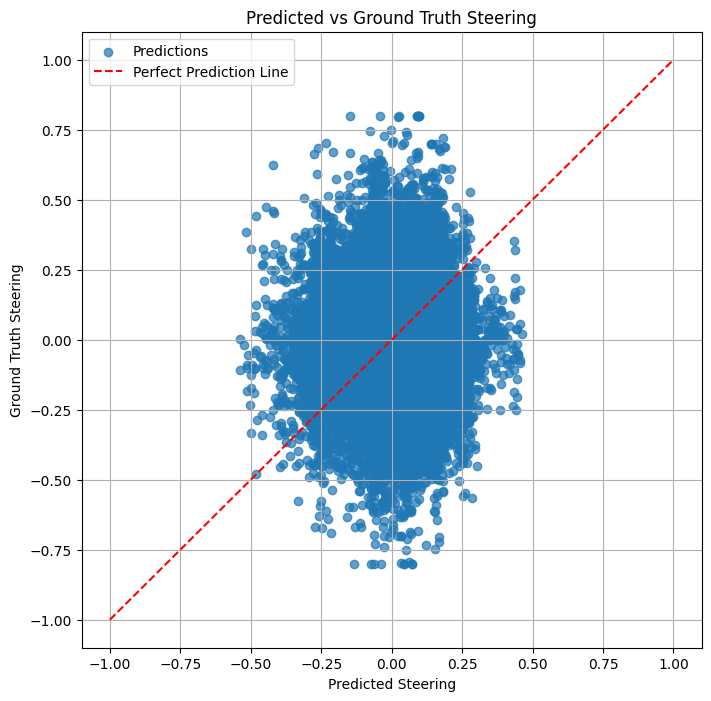

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


##### Scatter Plot: Predicted vs Ground Truth #####

ground_truth = labels_df['Steering']
predicted = labels_df['predicted_steering']   # Replace with your predicted data

plt.figure(figsize=(8, 8))
plt.scatter(predicted, ground_truth, alpha=0.7, label="Predictions")
plt.plot([-1, 1], [-1, 1], 'r--', label="Perfect Prediction Line")  # Diagonal line
plt.xlabel("Predicted Steering")
plt.ylabel("Ground Truth Steering")
plt.title("Predicted vs Ground Truth Steering")
plt.legend()
plt.grid()
plt.show()

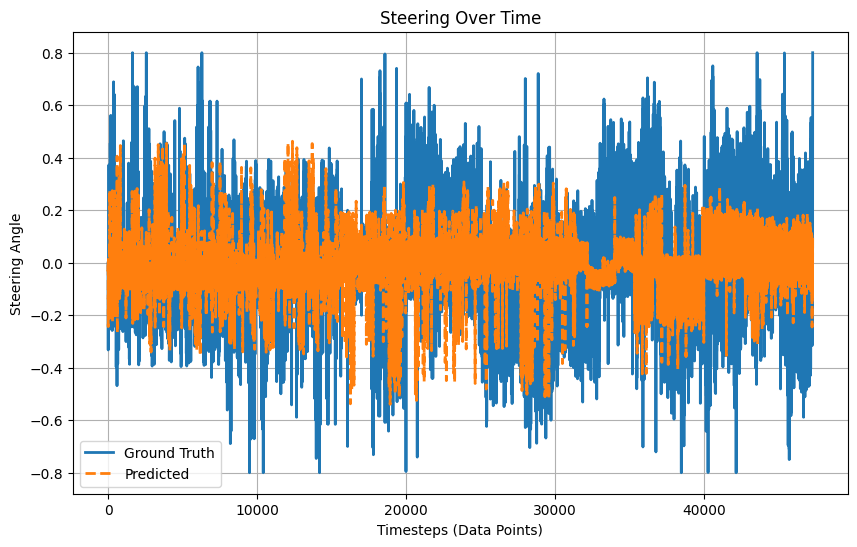

In [ ]:
##### Line Graph: Steering Over Time ######

timesteps = np.arange(len(ground_truth))  # Replace with your actual timesteps
plt.figure(figsize=(10, 6))
plt.plot(timesteps, ground_truth, label="Ground Truth", linewidth=2)
plt.plot(timesteps, predicted, label="Predicted", linestyle="dashed", linewidth=2)
plt.xlabel("Timesteps (Data Points)")
plt.ylabel("Steering Angle")
plt.title("Steering Over Time")
plt.legend()
plt.grid()
plt.show()